In [1]:
import numpy as np, tensorflow as tf, matplotlib.pyplot as plt, cv2, keras, seaborn

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
w, h = 50, 50

In [3]:
(X_train, y_train), (X_temp, y_temp) = mnist.load_data()

In [4]:
print(f'X_train : {X_train.shape}\ny_train : {y_train.shape}\n\nX_temp: {X_temp.shape}\ny_temp: {y_temp.shape}')

X_train : (60000, 28, 28)
y_train : (60000,)

X_temp: (10000, 28, 28)
y_temp: (10000,)


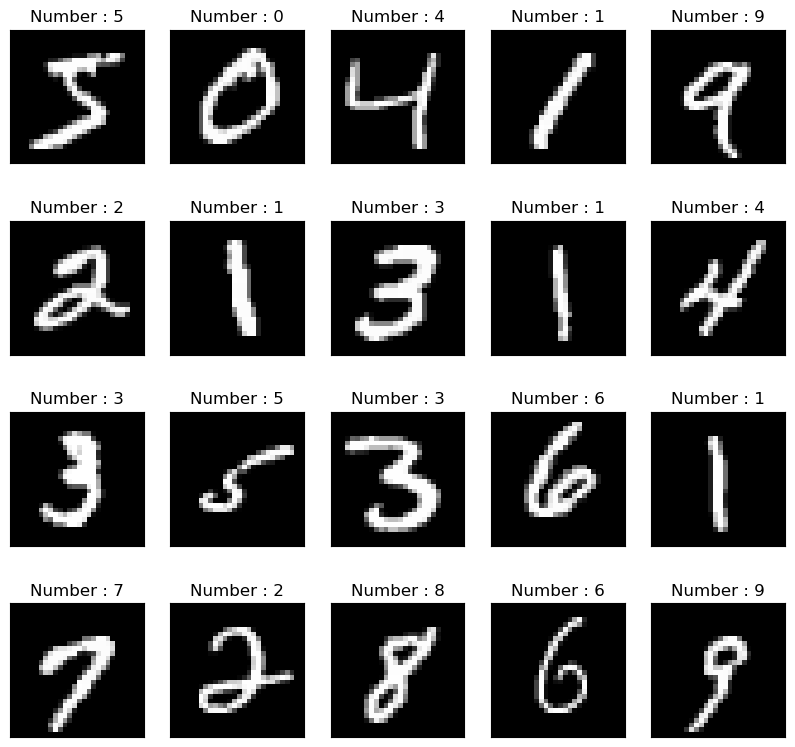

In [5]:
plt.figure(figsize=(10, 12))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train [i], cmap='gray')
    plt.title(f'Number : {y_train [i]}')
    plt.xticks([])
    plt.yticks([])
    plt.plot()

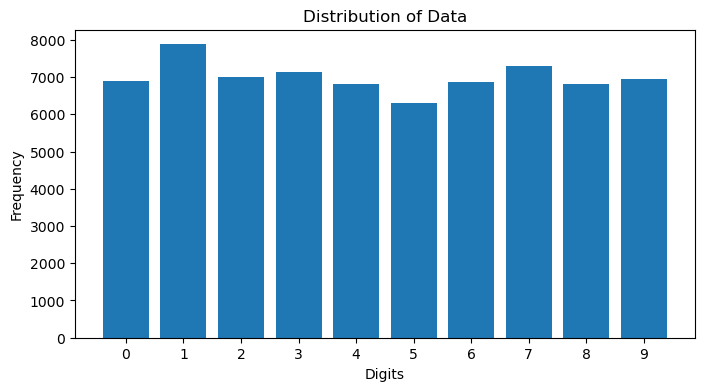

In [6]:
combine_data = np.concatenate((y_train, y_temp))

count = np.bincount(combine_data)

plt.figure(figsize=(8, 4))
plt.bar(x=np.arange(10), height=count)
plt.xticks(ticks=np.arange(10), labels=np.arange(10))
plt.title("Distribution of Data")
plt.xlabel("Digits")
plt.ylabel("Frequency")
plt.show()

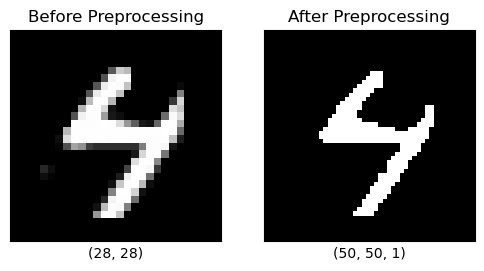

In [7]:
def image_preprocessing(image):  
    image = cv2.resize(image, (w, h))
    image = cv2.equalizeHist(image)
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.reshape(w, h, 1)
    binary_image = binary_image / 255.0
    return binary_image

target = X_train[991]

plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.title('Before Preprocessing')
plt.xlabel(f'{target.shape}')
plt.imshow(target, cmap='gray')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.title('After Preprocessing')
target_pre = image_preprocessing(target)
plt.xlabel(f'{target_pre.shape}')
plt.imshow(target_pre, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
def preprocess_mnist_images(images):
    return np.array([image_preprocessing(img) for img in images])

X_train = np.array([image_preprocessing(img) for img in X_train])
X_temp = np.array([image_preprocessing(img) for img in X_temp])

In [9]:
X_train.shape

(60000, 50, 50, 1)

In [10]:
dataGen = ImageDataGenerator(width_shift_range=.1, height_shift_range=.1, zoom_range=.2, shear_range=.1, rotation_range=10)

dataGen.fit(X_train)

In [11]:
y_train = to_categorical(y_train, 10)
y_temp = to_categorical(y_temp, 10)

In [12]:
# Train data split
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=.5, random_state=42, stratify=y_temp)

In [13]:
print(f'X_train : {X_train.shape}\ny_train : {y_train.shape}\n\nX_val: {X_val.shape}\ny_val: {y_val.shape}\n\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

X_train : (60000, 50, 50, 1)
y_train : (60000, 10)

X_val: (5000, 50, 50, 1)
y_val: (5000, 10)

X_test: (5000, 50, 50, 1)
y_test: (5000, 10)


In [14]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(w, h, 1)),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2), strides=2),
    Dropout(.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(.25),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# history = model.fit_generator(dataGen.flow(X_train, y_train), epochs=10, steps_per_epoch=500, validation_data=(X_val, y_val), shuffle=1)    

In [17]:
# model.save('./num_classifier.h5')

In [18]:
model = tf.keras.models.load_model('./num_classifier.h5')

In [19]:
model.evaluate(X_test, y_test)

157/157 [==============================] - 5s 22ms/step - loss: 0.0204 - accuracy: 0.9932


[0.020404212176799774, 0.9932000041007996]

In [20]:
y_pred = model.predict(X_test)
y_pred_labels = [np.argmax(i) for i in y_pred]

157/157 [==============================] - 5s 26ms/step


<Axes: >

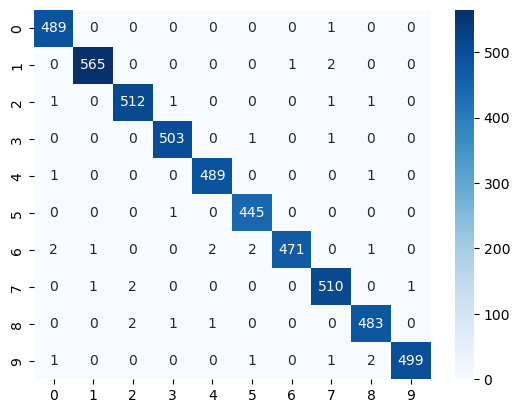

In [21]:
y_test_labels = [np.argmax(i) for i in y_test]
y_pred_labels = [np.argmax(i) for i in y_pred]


confusion_matrix = tf.math.confusion_matrix(labels=y_test_labels, predictions=y_pred_labels)
seaborn.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')

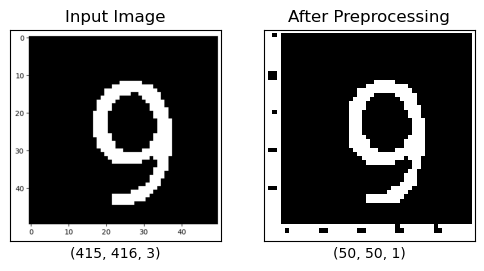

In [27]:
def image_preprocessing_input(image): 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    image = cv2.resize(image, (w, h))
    image = cv2.equalizeHist(image)
    _, binary_image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)
    binary_image = binary_image.reshape(w, h, 1)
    binary_image = binary_image / 255.0
    return binary_image

test_image = cv2.imread('./output_9.png')
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(test_image, cmap='gray')
plt.xlabel(f'{test_image.shape}')
plt.xticks([])
plt.yticks([])

test_image_preprocessed = image_preprocessing_input(test_image)
plt.subplot(1, 2, 2)
plt.title('After Preprocessing')
plt.imshow(test_image_preprocessed, cmap='gray')
plt.xlabel(f'{test_image_preprocessed.shape}')
plt.xticks([])
plt.yticks([])
plt.show()

In [28]:
test_image_preprocessed = np.expand_dims(test_image_preprocessed, axis=0)
test_image_preprocessed.shape

(1, 50, 50, 1)

In [29]:
y_pred = model.predict(test_image_preprocessed)
y_pred_labels = [np.argmax(i) for i in y_pred]
print(f'Prediction for sample: {y_pred_labels}')

1/1 [==============================] - 0s 30ms/step
Prediction for sample: [9]


In [ ]:
# y_pred = model.predict(test_image_preprocessed)
# y_pred_labels = [np.argmax(i) for i in y_pred] 
# print(f'Prediction: {y_pred_labels}')